# Data Full

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import cv2
from google.colab import drive
import random


In [ ]:
# Mount Google Drive (uncomment jika diperlukan untuk Google Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Configuration variables
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.00001

In [ ]:
# Tetapkan seed global
def set_seed(seed_value):
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

# Tetapkan seed
set_seed(42)

In [ ]:
# Konfigurasi path data
DATA_DIR = '/content/drive/MyDrive/TA/databasefic'  # direktori utama dataset
KARIES_DIR = os.path.join(DATA_DIR, 'karies')  # direktori gambar karies
SEHAT_DIR = os.path.join(DATA_DIR, 'sehat')   # direktori gambar sehat
PROCESSED_DIR = os.path.join(DATA_DIR, 'processed')  # direktori hasil preprocessing

In [ ]:
# ===== AWAL PEMERIKSAAN DATA =====
# Memeriksa jumlah gambar di setiap folder
jumlah_karies = len(os.listdir(KARIES_DIR))
jumlah_sehat = len(os.listdir(SEHAT_DIR))

print(f"Jumlah gambar karies: {jumlah_karies}")
print(f"Jumlah gambar sehat: {jumlah_sehat}")

Jumlah gambar karies: 215
Jumlah gambar sehat: 321


#Preprocessing Gambar

In [ ]:
def preprocess_image(img_path, output_path=None, denoise=True, clahe=True, save=False):
    """
    Fungsi untuk preprocessing gambar panoramik gigi

    Parameters:
    - img_path: Path ke gambar input
    - output_path: Path untuk menyimpan gambar hasil preprocessing (opsional)
    - denoise: Apakah menerapkan denoising
    - clahe: Apakah menerapkan Contrast Limited Adaptive Histogram Equalization
    - save: Apakah menyimpan hasil preprocessing

    Returns:
    - img_processed: Gambar yang telah diproses
    """
    # Baca gambar
    img = cv2.imread(img_path)

    if img is None:
        print(f"Error: Tidak dapat membaca gambar dari {img_path}")
        return None

    # Konversi ke grayscale jika gambar berwarna
    if len(img.shape) == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = img

    # Menerapkan denoising untuk mengurangi noise
    if denoise:
        img_gray = cv2.fastNlMeansDenoising(img_gray, None, 10, 7, 21)

    # Menerapkan CLAHE untuk meningkatkan kontras
    if clahe:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_processed = clahe.apply(img_gray)
    else:
        img_processed = img_gray

    # Menyimpan hasil preprocessing jika diperlukan
    if save and output_path:
        cv2.imwrite(output_path, img_processed)

    return img_processed

In [ ]:
# Fungsi untuk preprocessing batch gambar (dapat dijalankan secara opsional)
def batch_preprocess(input_dir, output_dir):
    """
    Memproses semua gambar dalam direktori dan menyimpan hasil
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    files = os.listdir(input_dir)
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            input_path = os.path.join(input_dir, file)
            output_path = os.path.join(output_dir, file)
            preprocess_image(input_path, output_path, save=True)
            print(f"Preprocessed: {file}")


In [ ]:
# CATATAN: Uncomment baris di bawah jika ingin melakukan preprocessing manual
batch_preprocess(KARIES_DIR, os.path.join(PROCESSED_DIR, 'processed_karies'))
batch_preprocess(SEHAT_DIR, os.path.join(PROCESSED_DIR, 'processed_sehat'))

Preprocessed: 111.jpg
Preprocessed: 115.jpg
Preprocessed: 108.jpg
Preprocessed: 106.jpg
Preprocessed: 103.jpg
Preprocessed: 113.jpg
Preprocessed: 13.jpg
Preprocessed: 144.jpg
Preprocessed: 122.jpg
Preprocessed: 138.jpg
Preprocessed: 135.jpg
Preprocessed: 12.jpg
Preprocessed: 152.jpg
Preprocessed: 123.jpg
Preprocessed: 130.jpg
Preprocessed: 153.jpg
Preprocessed: 147.jpg
Preprocessed: 148.jpg
Preprocessed: 182.jpg
Preprocessed: 192.jpg
Preprocessed: 169.jpg
Preprocessed: 173.jpg
Preprocessed: 191.jpg
Preprocessed: 164.jpg
Preprocessed: 163.jpg
Preprocessed: 175.jpg
Preprocessed: 16.jpg
Preprocessed: 160.jpg
Preprocessed: 161.jpg
Preprocessed: 158.jpg
Preprocessed: 18.jpg
Preprocessed: 187.jpg
Preprocessed: 170.jpg
Preprocessed: 190.jpg
Preprocessed: 171.jpg
Preprocessed: 186.jpg
Preprocessed: 221.jpg
Preprocessed: 220.jpg
Preprocessed: 200.jpg
Preprocessed: 226.jpg
Preprocessed: 207.jpg
Preprocessed: 201.jpg
Preprocessed: 228.jpg
Preprocessed: 21.jpg
Preprocessed: 211.jpg
Preprocessed: 2

#Preprocessing Data

In [ ]:
# ===== BAGIAN PRE-PROCESSING DATA =====
# Membuat generator data dengan augmentasi untuk data training
# Preprocessing meliputi:
# 1. Rescaling - Normalisasi nilai piksel dari 0-255 menjadi 0-1
# 2. Augmentasi data - Meningkatkan variasi data training
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi nilai piksel
    validation_split=0.2,  # 10% data untuk validasi
    rotation_range=20,  # Rotasi gambar hingga 20 derajat
    width_shift_range=0.2,  # Pergeseran horizontal
    height_shift_range=0.2,  # Pergeseran vertikal
    shear_range=0.2,  # Transformasi shear
    zoom_range=0.2,  # Zoom in/out
    horizontal_flip=True,  # Refleksi horizontal
    fill_mode='nearest',  # Strategi mengisi piksel baru
    # brightness_range=[0.8, 1.2]  # Variasi kecerahan (opsional untuk menangani kontras berbeda)
)


In [ ]:
# Generator untuk data validasi (hanya rescaling)
validation_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisasi nilai piksel
    validation_split=0.2  # 20% data untuk validasi
)

In [ ]:
# Memuat data dan menerapkan preprocessing
# target_size - Mengubah ukuran semua gambar menjadi 224x224 piksel (preprocessing ukuran)
train_generator = train_datagen.flow_from_directory(
    PROCESSED_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Resize gambar ke ukuran standar
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Klasifikasi biner: karies atau sehat
    subset='training',
    shuffle=True,  # Mengacak data untuk training
    seed=42
)

# Memuat data validasi
validation_generator = validation_datagen.flow_from_directory(
    PROCESSED_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Resize gambar ke ukuran standar
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,  # Tidak mengacak data validasi
    seed=42
)


Found 429 images belonging to 2 classes.
Found 107 images belonging to 2 classes.


# Building Model

In [ ]:
# Membangun model CNN
model = models.Sequential([
    # Layer konvolusi pertama
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Layer konvolusi kedua
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Layer konvolusi ketiga
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Layer konvolusi keempat
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Layer flatten untuk mengubah menjadi format 1D
    layers.Flatten(),

    # Fully connected layers
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Dropout untuk mengurangi overfitting
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),

    # Layer output
    layers.Dense(1, activation='sigmoid')  # sigmoid untuk klasifikasi biner
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Kompilasi model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
tf.keras.utils.set_random_seed(42)

In [ ]:
# Ringkasan model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,212,545 (99.99 MB)

 Trainable params: 26,211,585 (99.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Callbacks untuk training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

In [ ]:
# Menyimpan model terbaik
checkpoint_filepath = '/content/drive/MyDrive/TA/databasefic/hasilta7/model_karies_gigi.h5'
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

In [ ]:
# Melatih model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4668 - loss: 1.0566
Epoch 1: val_accuracy improved from -inf to 0.40187, saving model to /content/drive/MyDrive/TA/databasefic/hasilta7/model_karies_gigi.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 109s 7s/step - accuracy: 0.4695 - loss: 1.0531 - val_accuracy: 0.4019 - val_loss: 0.6992
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5532 - loss: 0.8642
Epoch 2: val_accuracy did not improve from 0.40187
14/14 ━━━━━━━━━━━━━━━━━━━━ 131s 7s/step - accuracy: 0.5517 - loss: 0.8662 - val_accuracy: 0.4019 - val_loss: 0.7105
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5260 - loss: 0.8901
Epoch 3: val_accuracy did not improve from 0.40187
14/14 ━━━━━━━━━━━━━━━━━━━━ 104s 7s/step - accuracy: 0.5278 - loss: 0.8889 - val_accuracy: 0.4019 - val_loss: 0.7117
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5549 - loss: 0.8557
Epoch 4: val_accuracy did not improve from 0.40187
14/14 ━━━━━━━━━━━━━━━━━━━━ 95s 7s/step - accuracy: 0.5553 - loss: 0.8558 - val_accuracy: 0.4019 - val_loss: 0.7100
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5405 - loss: 0.8469
Epoch 5: val_accuracy did not improve from 0.40187
1

14/14 ━━━━━━━━━━━━━━━━━━━━ 107s 8s/step - accuracy: 0.5015 - loss: 0.7807 - val_accuracy: 0.4206 - val_loss: 0.7224
Epoch 24/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5746 - loss: 0.7191
Epoch 24: val_accuracy improved from 0.42056 to 0.46729, saving model to /content/drive/MyDrive/TA/databasefic/hasilta7/model_karies_gigi.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 108s 7s/step - accuracy: 0.5736 - loss: 0.7203 - val_accuracy: 0.4673 - val_loss: 0.7028
Epoch 25/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5999 - loss: 0.7413
Epoch 25: val_accuracy improved from 0.46729 to 0.53271, saving model to /content/drive/MyDrive/TA/databasefic/hasilta7/model_karies_gigi.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 115s 8s/step - accuracy: 0.5994 - loss: 0.7389 - val_accuracy: 0.5327 - val_loss: 0.6890
Epoch 26/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5084 - loss: 0.7652
Epoch 26: val_accuracy improved from 0.53271 to 0.57009, saving model to /content/drive/MyDrive/TA/databasefic/hasilta7/model_karies_gigi.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 131s 7s/step - accuracy: 0.5107 - loss: 0.7624 - val_accuracy: 0.5701 - val_loss: 0.6863
Epoch 27/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5912 - loss: 0.7535
Epoch 27: val_accuracy did not improve from 0.57009
14/14 ━━━━━━━━━━━━━━━━━━━━ 102s 7s/step - accuracy: 0.5885 - loss: 0.7538 - val_accuracy: 0.4673 - val_loss: 0.6929
Epoch 28/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6026 - loss: 0.6872
Epoch 28: val_accuracy did not improve from 0.57009
14/14 ━━━━━━━━━━━━━━━━━━━━ 140s 7s/step - accuracy: 0.6033 - loss: 0.6879 - val_accuracy: 0.4766 - val_loss: 0.7023
Epoch 29/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5811 - loss: 0.7724
Epoch 29: val_accuracy did not improve from 0.57009
14/14 ━━━━━━━━━━━━━━━━━━━━ 95s 7s/step - accuracy: 0.5784 - loss: 0.7717 - val_accuracy: 0.5047 - val_loss: 0.6978
Epoch 30/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5774 - loss: 0.6802
Epoch 30: val_accuracy did not improve from 0

14/14 ━━━━━━━━━━━━━━━━━━━━ 103s 7s/step - accuracy: 0.6001 - loss: 0.6882 - val_accuracy: 0.6075 - val_loss: 0.6659
Epoch 38/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5559 - loss: 0.7299
Epoch 38: val_accuracy did not improve from 0.60748
14/14 ━━━━━━━━━━━━━━━━━━━━ 113s 8s/step - accuracy: 0.5561 - loss: 0.7305 - val_accuracy: 0.6075 - val_loss: 0.6636
Epoch 39/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5695 - loss: 0.7228
Epoch 39: val_accuracy did not improve from 0.60748
14/14 ━━━━━━━━━━━━━━━━━━━━ 93s 6s/step - accuracy: 0.5701 - loss: 0.7218 - val_accuracy: 0.6075 - val_loss: 0.6582
Epoch 40/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6671 - loss: 0.6515
Epoch 40: val_accuracy improved from 0.60748 to 0.62617, saving model to /content/drive/MyDrive/TA/databasefic/hasilta7/model_karies_gigi.h5


14/14 ━━━━━━━━━━━━━━━━━━━━ 102s 7s/step - accuracy: 0.6643 - loss: 0.6532 - val_accuracy: 0.6262 - val_loss: 0.6505
Epoch 41/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5774 - loss: 0.7167
Epoch 41: val_accuracy did not improve from 0.62617
14/14 ━━━━━━━━━━━━━━━━━━━━ 101s 7s/step - accuracy: 0.5771 - loss: 0.7182 - val_accuracy: 0.6075 - val_loss: 0.6498
Epoch 42/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5862 - loss: 0.7434
Epoch 42: val_accuracy did not improve from 0.62617
14/14 ━━━━━━━━━━━━━━━━━━━━ 94s 7s/step - accuracy: 0.5849 - loss: 0.7430 - val_accuracy: 0.5981 - val_loss: 0.6529
Epoch 43/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6128 - loss: 0.6692
Epoch 43: val_accuracy did not improve from 0.62617
14/14 ━━━━━━━━━━━━━━━━━━━━ 142s 7s/step - accuracy: 0.6114 - loss: 0.6709 - val_accuracy: 0.5794 - val_loss: 0.6543
Epoch 44/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5841 - loss: 0.6921
Epoch 44: val_accuracy did not improve from 0

14/14 ━━━━━━━━━━━━━━━━━━━━ 140s 7s/step - accuracy: 0.6103 - loss: 0.6771 - val_accuracy: 0.6355 - val_loss: 0.6641
Epoch 49/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5915 - loss: 0.7318
Epoch 49: val_accuracy did not improve from 0.63551
14/14 ━━━━━━━━━━━━━━━━━━━━ 112s 8s/step - accuracy: 0.5920 - loss: 0.7309 - val_accuracy: 0.6168 - val_loss: 0.6571
Epoch 50/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6171 - loss: 0.7151
Epoch 50: val_accuracy did not improve from 0.63551
14/14 ━━━━━━━━━━━━━━━━━━━━ 100s 7s/step - accuracy: 0.6173 - loss: 0.7147 - val_accuracy: 0.6355 - val_loss: 0.6629


#Evaluation

In [ ]:
# Menampilkan hasil terbaik dari training
best_val_acc_idx = np.argmax(history.history['val_accuracy'])
best_train_acc = history.history['accuracy'][best_val_acc_idx]
best_val_acc = history.history['val_accuracy'][best_val_acc_idx]
best_epoch = best_val_acc_idx + 1

print("\nHasil Terbaik dari Training:")
print(f"Epoch terbaik: {best_epoch}")
print(f"Akurasi training terbaik: {best_train_acc:.4f}")
print(f"Akurasi validasi terbaik: {best_val_acc:.4f}")


Hasil Terbaik dari Training:
Epoch terbaik: 48
Akurasi training terbaik: 0.5897
Akurasi validasi terbaik: 0.6355


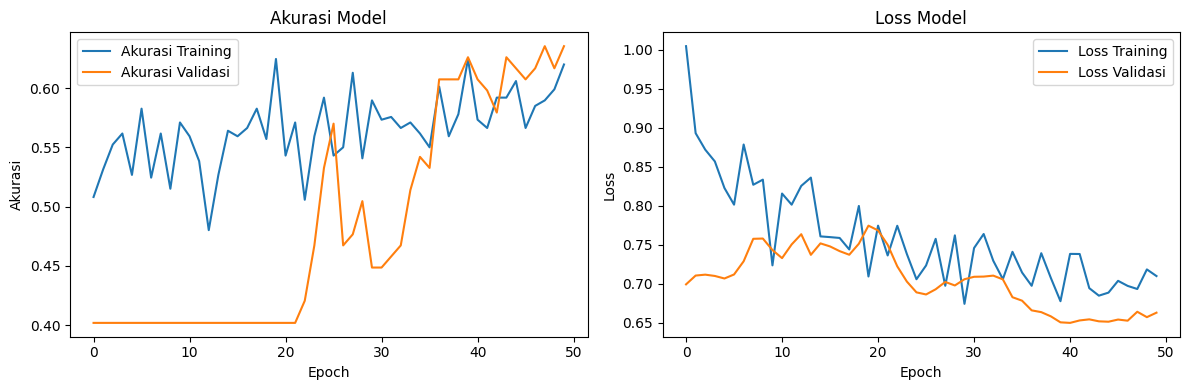

In [ ]:
# Visualisasi hasil training
plt.figure(figsize=(12, 4))

# Plot akurasi training dan validasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Training')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

# Plot loss training dan validasi
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Training')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/TA/databasefic/hasilta7/training_history.png')
plt.show()

In [ ]:
# Evaluasi model pada data validasi
validation_generator.reset()
y_pred_probs = model.predict(validation_generator)
y_pred = (y_pred_probs > 0.5).astype(int)
y_true = validation_generator.classes

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


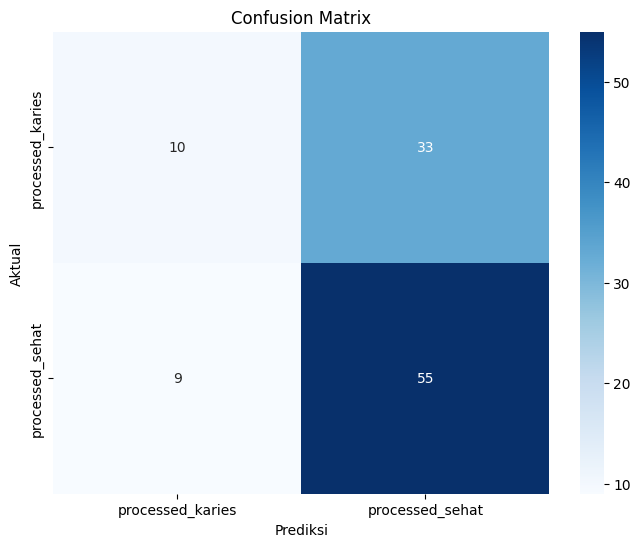

In [ ]:
# Hitung dan tampilkan confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(validation_generator.class_indices.keys()),
            yticklabels=list(validation_generator.class_indices.keys()))
plt.title('Confusion Matrix')
plt.ylabel('Aktual')
plt.xlabel('Prediksi')
plt.savefig('/content/drive/MyDrive/TA/databasefic/hasilta7/confusion_matrix.png')
plt.show()

In [ ]:
# Cetak laporan klasifikasi
print("\nLaporan Klasifikasi:")
print(classification_report(
    y_true,
    y_pred,
    target_names=list(validation_generator.class_indices.keys())
))


Laporan Klasifikasi:
                  precision    recall  f1-score   support

processed_karies       0.53      0.23      0.32        43
 processed_sehat       0.62      0.86      0.72        64

        accuracy                           0.61       107
       macro avg       0.58      0.55      0.52       107
    weighted avg       0.59      0.61      0.56       107



In [ ]:
# Menyimpan model final
model.save('/content/drive/MyDrive/TA/databasefic/hasilta7/model_karies_gigi_final.h5')